# NBA Winner Classifier

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#pd.options.display.max_columns = None
#pd.set_option("display.max_colwidth", None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#pd.set_option("display.max_rows", None)
import model.train as train
import model.config as model_config
import utils
import model.dataset.data as data
import model.dataset.season_game as sg
import utils_nba_winner_clf as utils_exp
import qgrid
from yellowbrick import classifier, features
from pandas_profiling import ProfileReport

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

/home/nathaniel/anaconda3/envs/nba-predictor/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

sns.set(style="whitegrid", palette="husl")

### Utils functions

In [3]:
def del_exp_result(exp_name):
    for idx, res in enumerate(list(utils_exp.exp_results)):
        if res['exp_name'] == exp_name:
            del utils_exp.exp_results[idx]

In [4]:
def show_qgrid(df_):
    qgrid_widget = qgrid.show_grid(df_, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
    qgrid_widget

In [5]:
def plot_results(experiment_name, results, figsize=(20,10)):
    plt.figure(figsize=figsize)
    results_df = utils.map_results_to_df(results)
    a = sns.pointplot(data=results_df,
              kind="point", x="season_test", y="balanced_accuracy", hue="model"
              )
    a.set_title(
        f"{experiment_name}-balanced_accuracy")
    a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [6]:
def get_results_df():
    return pd.DataFrame(utils_exp.exp_results)

In [7]:
metrics = ['precision', 'balanced_accuracy', 'roc_auc']

def print_prettier_exp_results(exp_name, metric='roc_auc'):
    ba_df = get_results_df()[['exp_name', 'model',
       f'{metric}_mean', f'{metric}_std']]
    return ba_df[ba_df.exp_name == exp_name].sort_values(by=[f"{metric}_mean"], ascending=False)

## Load Dataset

In [8]:
season_games = sg.load_season_games_dataset()

## Dataset


In [9]:
season_games.groupby(by="SEASON").count()["GAME_DATE_EST"]

SEASON
2002    1189
2003    1189
2004    1230
2005    1230
2006    1230
2007    1230
2008    1230
2009    1230
2010    1230
2011     990
2012    1229
2013    1230
2014    1230
2015    1230
2016    1230
2017    1230
2018    1230
2019    1059
Name: GAME_DATE_EST, dtype: int64

Podemos observar que no todas las temporadas tiene la misma cantidad de partidos. Esto es debido a la siguientes razones:

- 2011: Los jugadores hicieron una huelga debido a no estar de acuerdo con los salarios de los mismos y el limite salarial de las franquicias.
- 2012: Un partido entre el equipo de Boston e Indiana fue suspedindo el cual despues no fue reprogramado, y al final de la temporada se decidio ya no reprogramarlo debido a que la clasificacion a playoff ya estaba decidida y no afectaba el resultado.

Por tanto se seleccionaran solo las temporadas a partir del 2013(inclusive).

In [10]:
df = season_games[season_games.SEASON >= 2013]
seasons_size = len(df.SEASON.unique())
seasons = list(df.SEASON.unique())

## Experiments

### Feature Selection

In [20]:
TARGET = "HOME_WINS"
exp_X_columns = model_config.X_COLS
exp_y_columns = model_config.Y_CLF_COL

In [21]:
# function that filters vowels 
columns = ["W_L_ML5_HOME", "PLUS_MINUS_ML5_HOME", "W_L_ML5_AWAY", "PLUS_MINUS_ML5_AWAY"]
def fun(column): 
    if (column not in columns): 
        return True
    else: 
        return False

In [22]:
exp_X_columns = list(filter(fun, exp_X_columns))

In [24]:
exp_X_columns

['W_L_CUM_HOME',
 'W_L_L10_CUM_HOME',
 'FG_PCT_ML5_HOME',
 'FG3_PCT_ML5_HOME',
 'FT_PCT_ML5_HOME',
 'REB_ML5_HOME',
 'AST_ML5_HOME',
 'STL_ML5_HOME',
 'BLK_ML5_HOME',
 'TOV_ML5_HOME',
 'FG_PCT_MEAN_HOME',
 'FG3_PCT_MEAN_HOME',
 'FT_PCT_MEAN_HOME',
 'REB_MEAN_HOME',
 'AST_MEAN_HOME',
 'STL_MEAN_HOME',
 'BLK_MEAN_HOME',
 'TOV_MEAN_HOME',
 'PTS_MEAN_HOME',
 'PLUS_MINUS_MEAN_HOME',
 'FG_PCT_L10_HOME',
 'FG3_PCT_L10_HOME',
 'FT_PCT_L10_HOME',
 'REB_L10_HOME',
 'AST_L10_HOME',
 'STL_L10_HOME',
 'BLK_L10_HOME',
 'TOV_L10_HOME',
 'PLUS_MINUS_L10_HOME',
 'W_L_CUM_AWAY',
 'W_L_L10_CUM_AWAY',
 'FG_PCT_ML5_AWAY',
 'FG3_PCT_ML5_AWAY',
 'FT_PCT_ML5_AWAY',
 'REB_ML5_AWAY',
 'AST_ML5_AWAY',
 'STL_ML5_AWAY',
 'BLK_ML5_AWAY',
 'TOV_ML5_AWAY',
 'FG_PCT_MEAN_AWAY',
 'FG3_PCT_MEAN_AWAY',
 'FT_PCT_MEAN_AWAY',
 'REB_MEAN_AWAY',
 'AST_MEAN_AWAY',
 'STL_MEAN_AWAY',
 'BLK_MEAN_AWAY',
 'TOV_MEAN_AWAY',
 'PTS_MEAN_AWAY',
 'PLUS_MINUS_MEAN_AWAY',
 'FG_PCT_L10_AWAY',
 'FG3_PCT_L10_AWAY',
 'FT_PCT_L10_AWAY',
 'REB_L

### Setup

In [25]:
exp_prefix = "fs_"
exp_group_name = "fs_experiments"
results_total = []
utils_exp.exp_results = []

models = utils_exp.get_clf_models()

sscv = utils.SeasonSeriesSplit(df)
df_sscv = sscv.get_df()
X = df_sscv[exp_X_columns]
y = df_sscv[TARGET]

#utils_exp.exp_results = utils.deserialize_object(exp_group_name)

### Experiment using 1 season

In [26]:
experiment_name = f"{exp_prefix}1_season"
#del_exp_result(experiment_name)

folds, train_seasons, test_seasons = sscv.split(train_size=1, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 1_season
Done


,exp_name,model,roc_auc_mean,roc_auc_std
3,1_season,SVM,0.757730,0.011099
0,1_season,LR,0.754398,0.013241
4,1_season,RF,0.741280,0.011973
6,1_season,LGB,0.737826,0.004925
5,1_season,XGB,0.736043,0.007268
1,1_season,KNN,0.725867,0.014956
2,1_season,DT,0.660099,0.025832


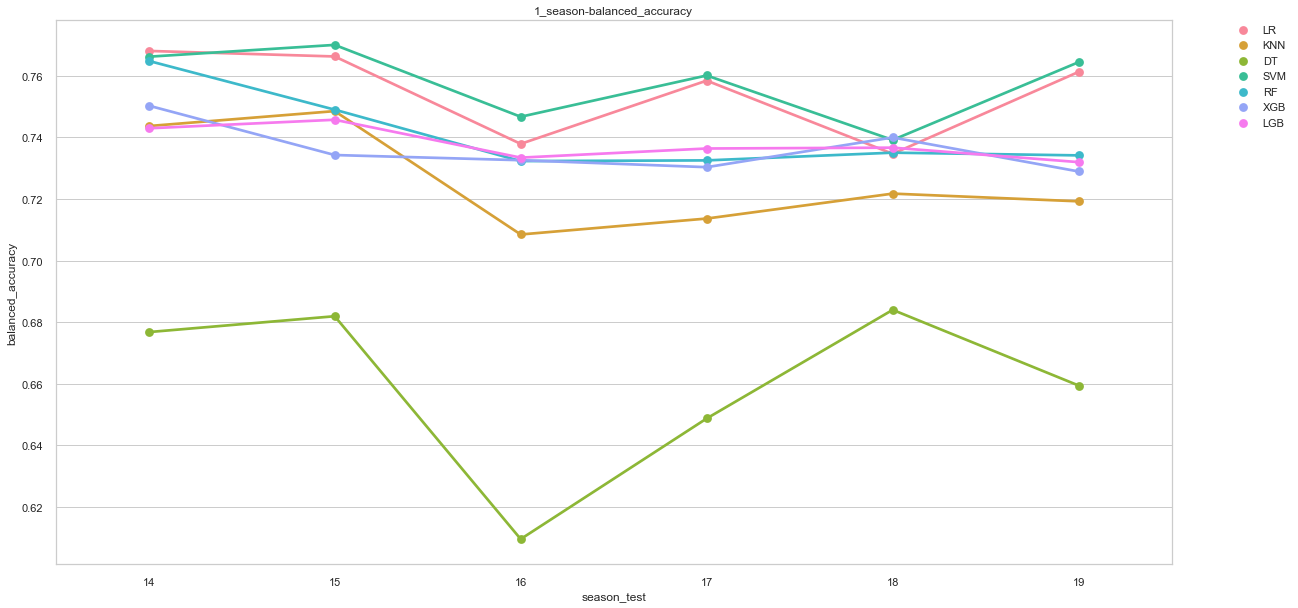

In [27]:
#### Visualize experiments results
plot_results(experiment_name, results, figsize=(20,10))

### Experiment: train: 2s; test: 1s

In [28]:
experiment_name = f"{exp_prefix}2_seasons"

folds, train_seasons, test_seasons = sscv.split(train_size=2, test_size=1)
params = (experiment_name, models, folds, train_seasons, test_seasons, X, y)
names, results = utils_exp.run_experiment(*params)
results_total.append((experiment_name, results))

print_prettier_exp_results(experiment_name)

Running experiment 2_seasons
Done


,exp_name,model,roc_auc_mean,roc_auc_std
10,2_seasons,SVM,0.758044,0.011511
7,2_seasons,LR,0.757083,0.010119
12,2_seasons,XGB,0.749314,0.008333
11,2_seasons,RF,0.746091,0.011875
13,2_seasons,LGB,0.741933,0.008908
8,2_seasons,KNN,0.725812,0.011523
9,2_seasons,DT,0.656356,0.012271


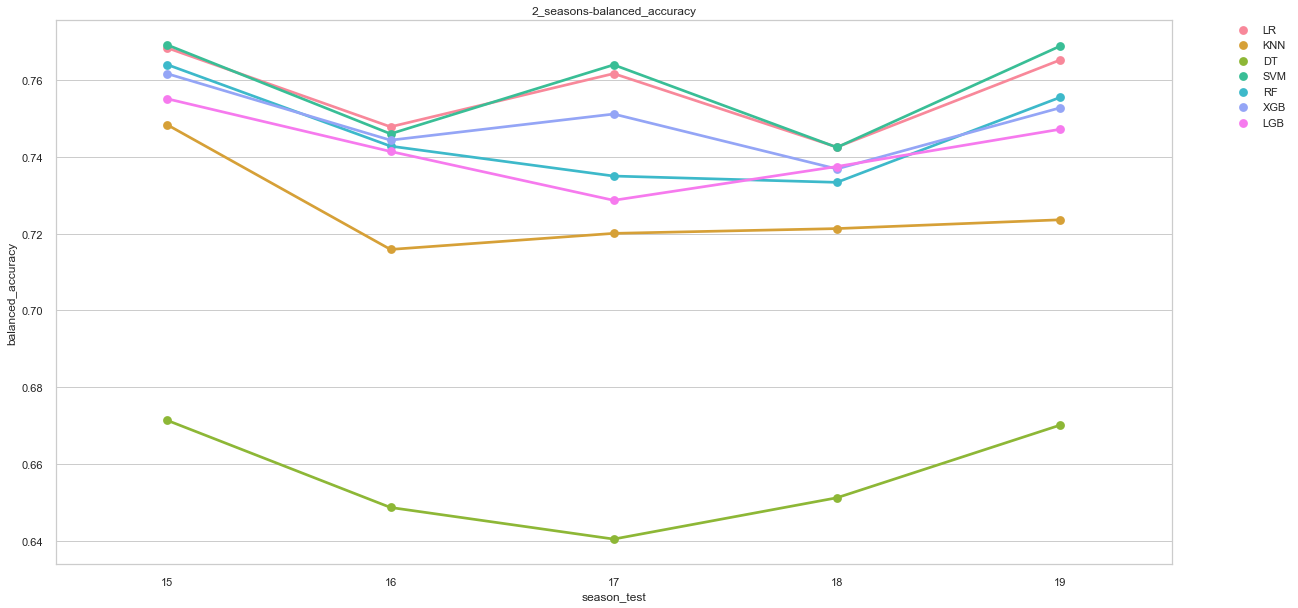

In [29]:
plot_results(experiment_name, results, figsize=(20,10))

### Experiments comparison

In [30]:
utils.serialize_object(exp_group_name, utils_exp.exp_results)

In [31]:
exp_df = get_results_df()

In [32]:
ba_df = exp_df[['exp_name', 'model',
       'balanced_accuracy_mean', 'balanced_accuracy_std']]

In [33]:
#show_qgrid(exp_df)
qgrid_widget = qgrid.show_grid(ba_df, show_toolbar=True , grid_options={'forceFitColumns': False, 'defaultColumnWidth': 200})
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [34]:
ba_df.sort_values(
    by=["balanced_accuracy_mean"]
    , ascending=False)[:6].reset_index().drop(labels=["index"], axis=1)

,exp_name,model,balanced_accuracy_mean,balanced_accuracy_std
0,2_seasons,SVM,0.758044,0.011511
1,1_season,SVM,0.757730,0.011099
2,2_seasons,LR,0.757083,0.010119
3,1_season,LR,0.754398,0.013241
4,2_seasons,XGB,0.749314,0.008333
5,2_seasons,RF,0.746091,0.011875


### Plot experiment results

In [35]:
utils.serialize_object("results", utils_exp.exp_results)
utils.serialize_object("results_total", results_total)

#### Balance Accuracy

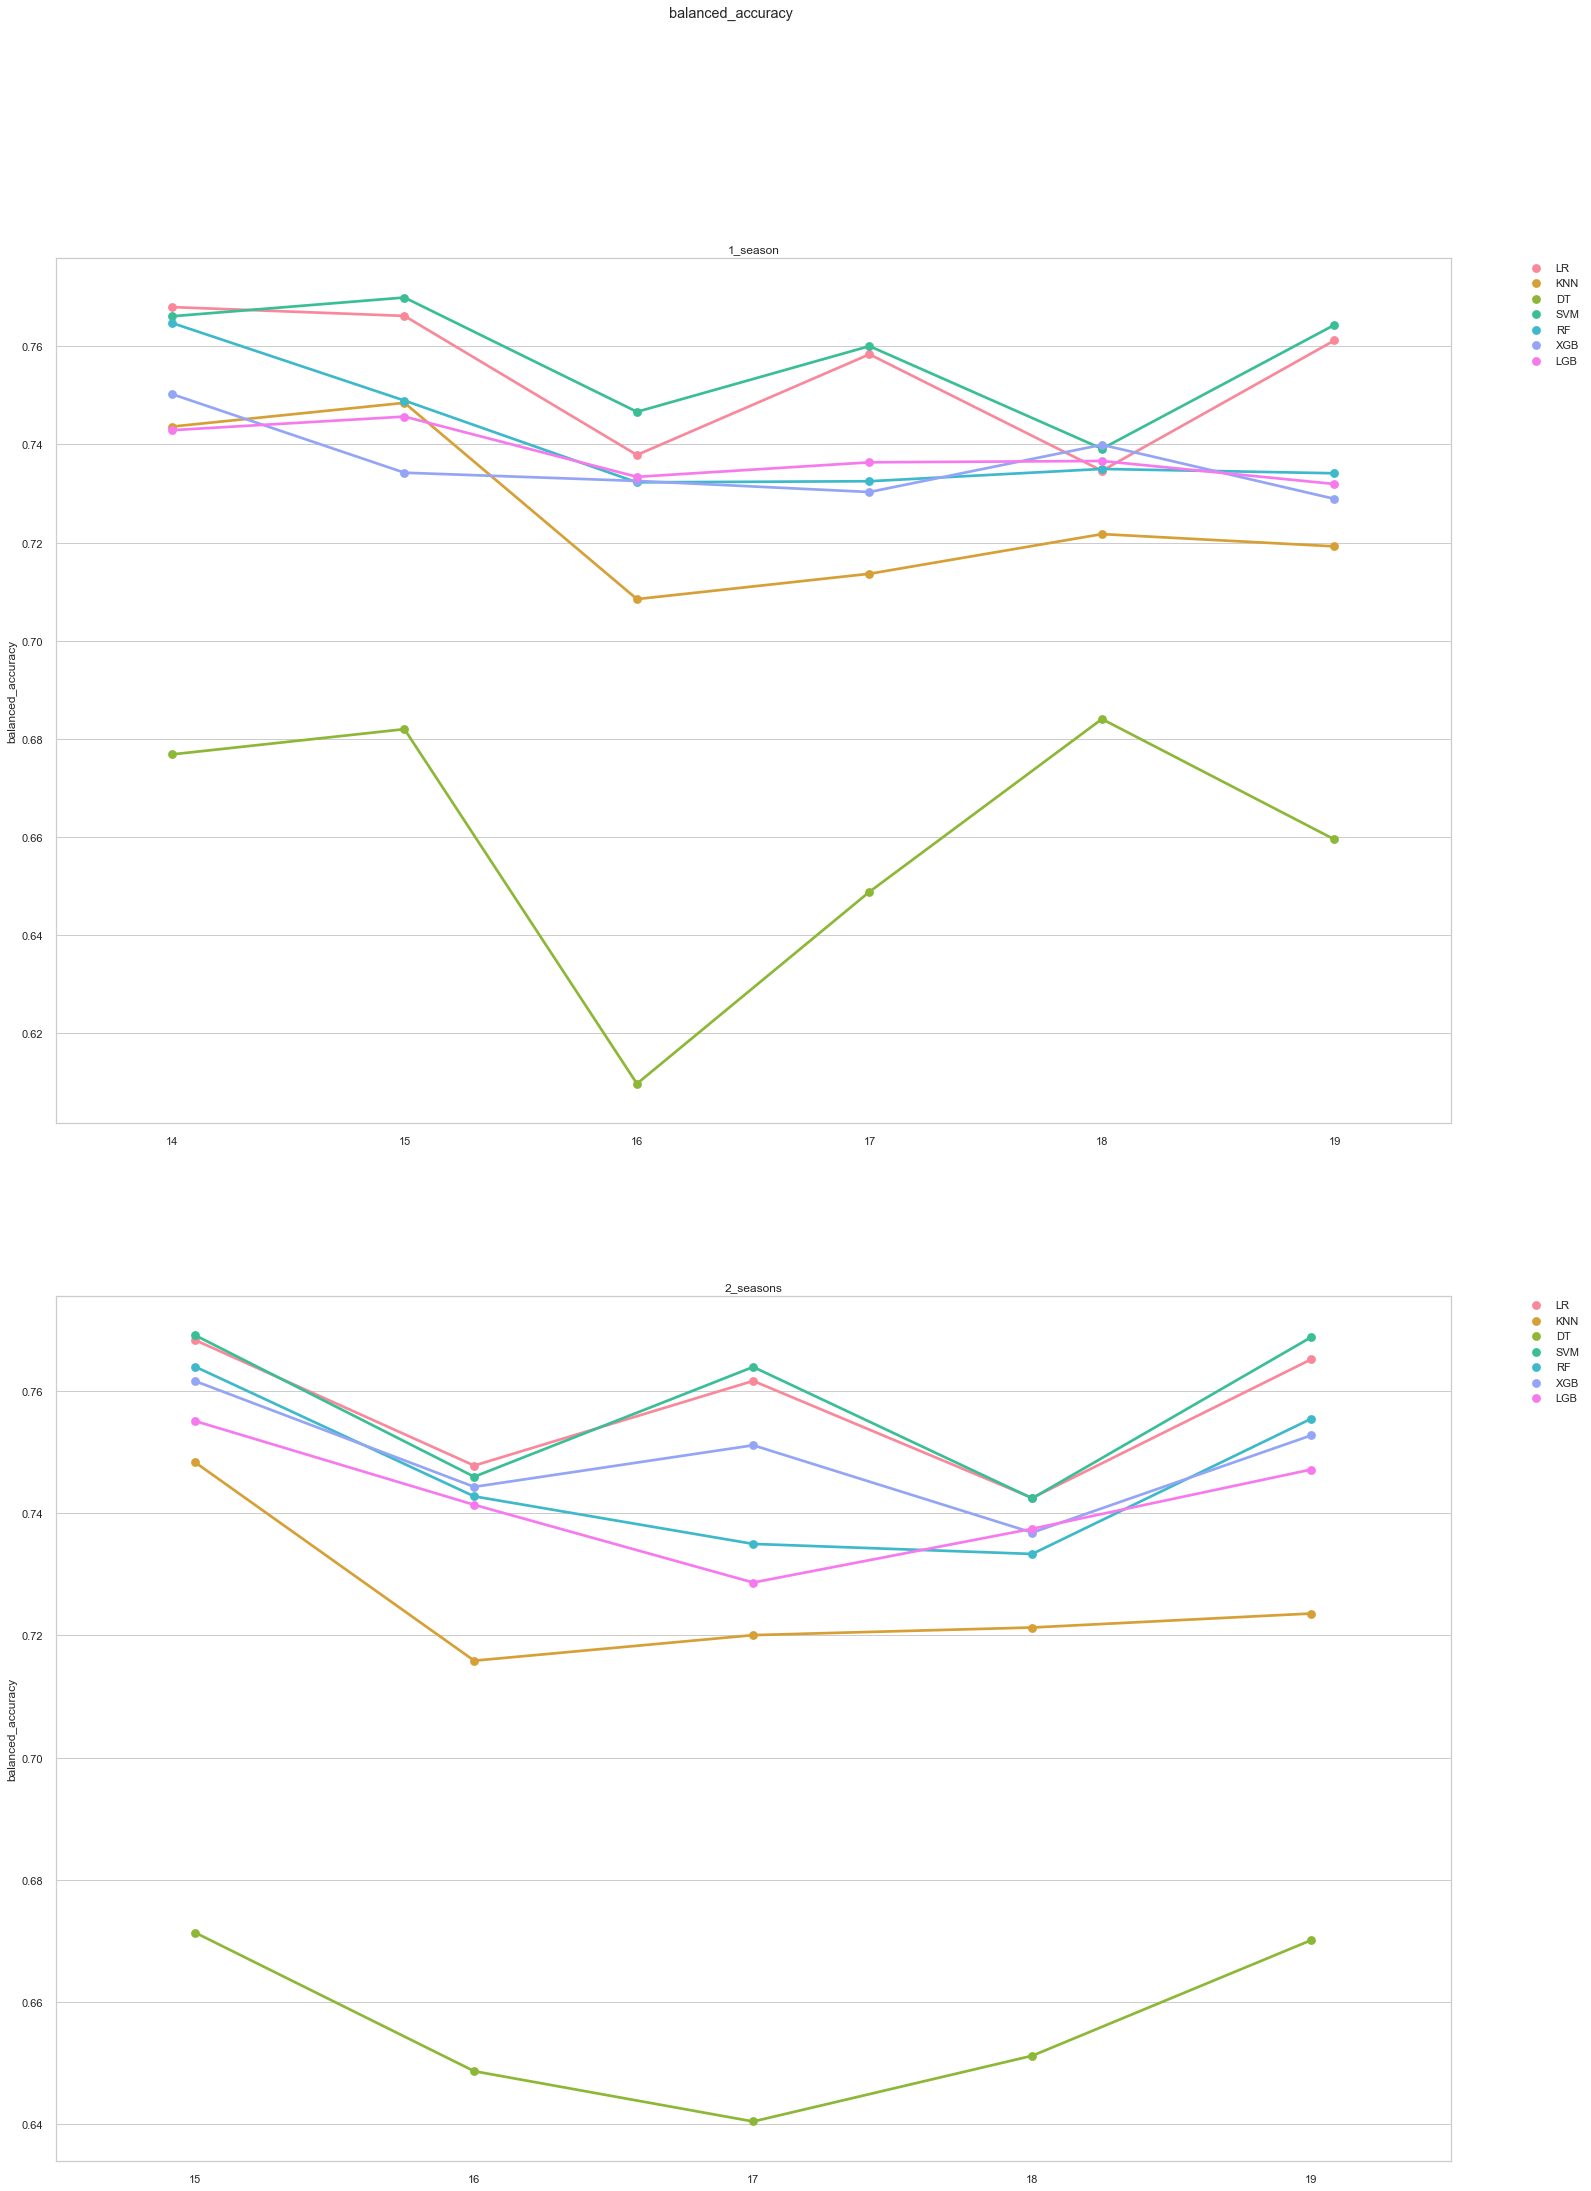

In [36]:
utils.plot_to_compare_experiments(
    results_total,
    metric="balanced_accuracy",
    figsize=(25, 35),
    use_pointplot=True
)

#### Precision

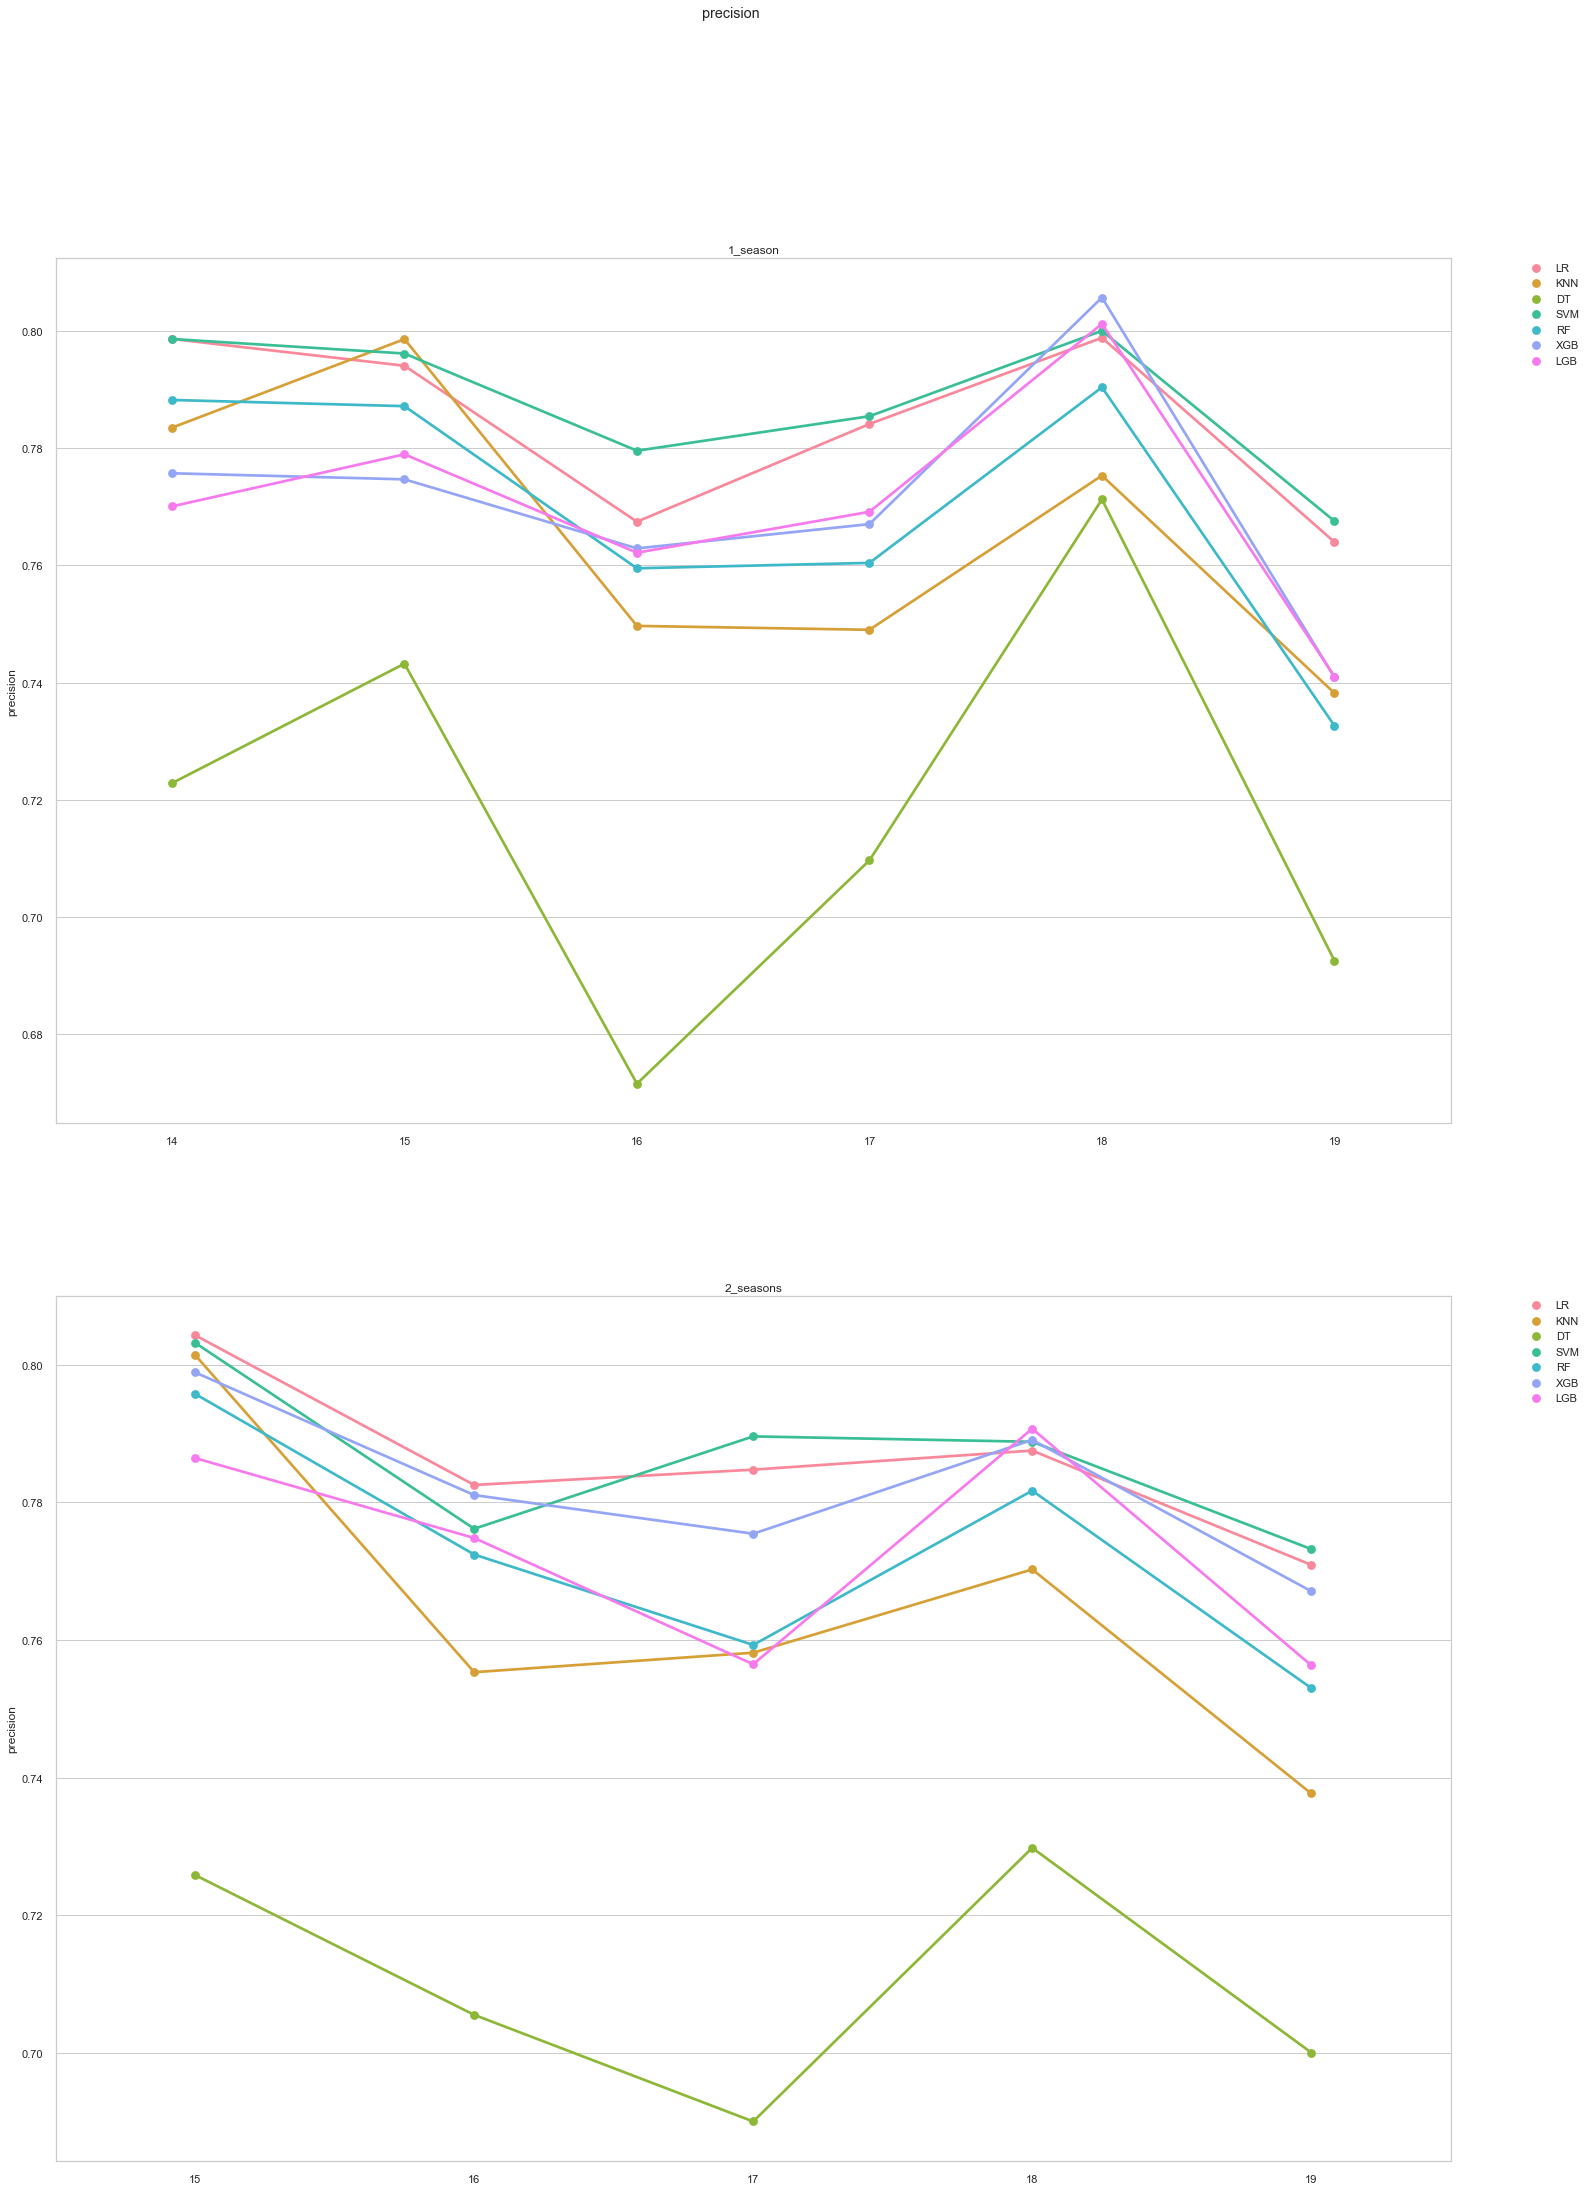

In [37]:
utils.plot_to_compare_experiments(
    results_total,
    metric="precision",
    figsize=(25, 35),
    use_pointplot=True
)

#### ROC AUC

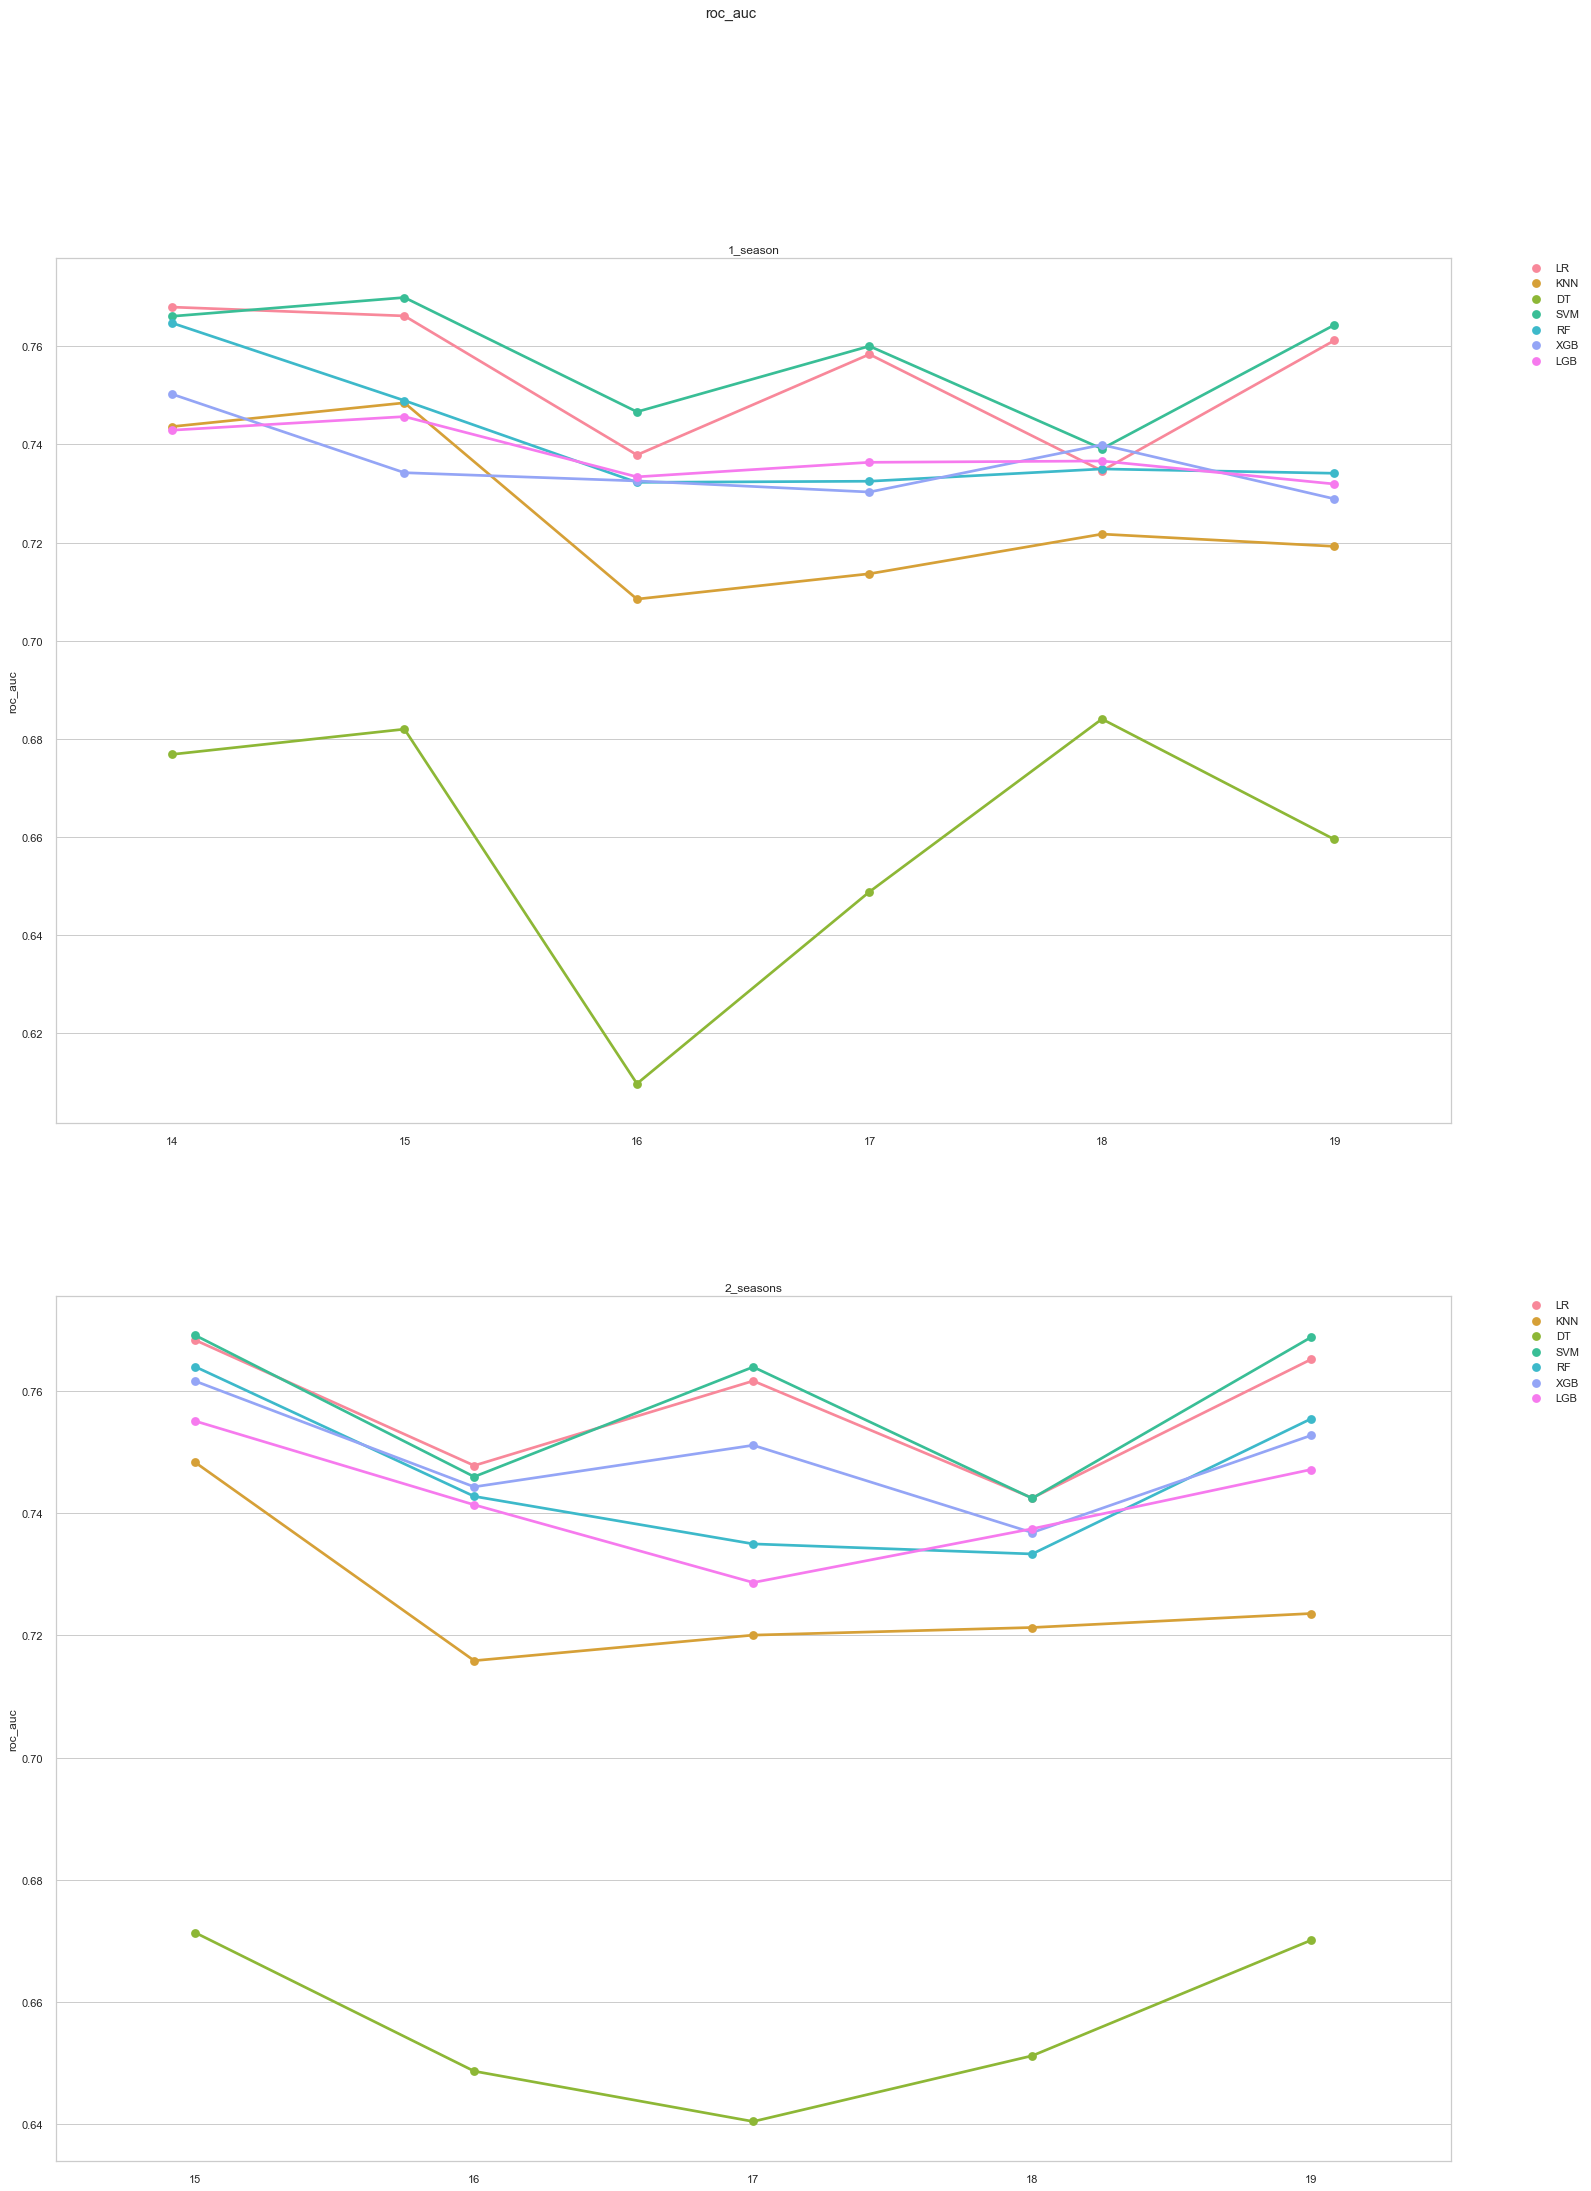

In [38]:
utils.plot_to_compare_experiments(
    results_total,
    metric="roc_auc",
    figsize=(25, 35),
    use_pointplot=True
)